## Hands-on Tutorial: Quantifying and Reducing Gender Stereotypes in Word Embeddings

Ensuring fairness in algorithmically-driven decision-making is important to avoid inadvertent cases of bias and perpetuation of harmful stereotypes. However, modern natural language processing techniques, which learn model parameters based on data, might rely on implicit biases presented in the data to make undesirable stereotypical associations. Such a danger is facing us with word embedding, a popular framework to represent text data as vectors which has been used in many machine learning and natural language processing tasks. Recent results ([1](https://arxiv.org/abs/1607.06520), [2](https://arxiv.org/abs/1608.07187)) show that even word embeddings trained on Google News articles exhibit female/male gender stereotypes to a disturbing extent. This raises concerns because of their widespread use, as we describe, often tends to amplify these biases. 

In the following, we provide step-by-step instructions to demonstrate and quanitfy the biases in word embedding.



In [9]:
# Setup:
# Clone the code repository from https://github.com/tolga-b/debiaswe.git
# mkdir debiaswe_tutorial
# cd debiaswe_tutorial
# git clone https://github.com/tolga-b/debiaswe.git

# To reduce the time of downloading data, we provide as subset of GoogleNews-vectors in the following location:
# https://drive.google.com/file/d/1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG/view?usp=sharing

# For full embeddings:
# Download embeddings at https://github.com/tolga-b/debiaswe and put them on the following directory
# embeddings/GoogleNews-vectors-negative300-hard-debiased.bin
# embeddings/GoogleNews-vectors-negative300.bin

In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions
import re
import tqdm

### Downlaod the itwac embeddings from [here](https://drive.google.com/file/d/1xSxLkf7KgFVPaR3mlKxgWORosAwyIcs8/view?usp=sharing) or execute the code below

## Part 1: Gender Bias in Word Embedding


### Step 1: Load data
We first load the word embedding trained on a corpus of Google News texts consisting of 3 million English words and terms. The embedding maps each word into a 300-dimension vector. 

In [30]:
#E = WordEmbedding('./embeddings/itwac128.tsv')

*** Reading data from ./embeddings/itwac128.tsv
(1247492, 128)
1247492 words of dimension 128 : ,, di, ., e, ..., minore-genitore/i, Babelzilla, Spaziolaboratorio, eorismo


In [35]:
"""E.filter_words(lambda w: w.isalpha() and w.islower())

with open('./embeddings/filtered_itwac128.tsv',"w") as file:
    for word in tqdm.tqdm(E.words):
        string_to_write = "\t".join([word] + list(map(str, list(E.v(word)))))+"\n"
        file.write(string_to_write, )"""

537325 words of dimension 128 : di, e, che, la, ..., checcosf, dacris, pawprint, eorismo


100%|██████████| 537325/537325 [00:40<00:00, 13254.58it/s]


In [36]:
E = WordEmbedding('./embeddings/filtered_itwac128.tsv')

*** Reading data from ./embeddings/filtered_itwac128.tsv
(537325, 128)
537325 words of dimension 128 : di, e, che, la, ..., checcosf, dacris, pawprint, eorismo


### Step 2: Define gender direction

We define gender direction by the direciton of she - he because they are frequent and do not have fewer alternative word senses (e.g., man can also refer to mankind). In the paper, we discuss alternative approach for defining gender direction (e.g., using PCA).

<BarContainer object of 10 artists>

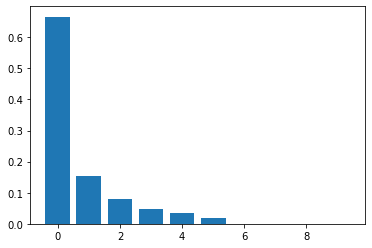

In [38]:
# compute gender direction
female_words = ["lei", "donna", "madre", "moglie", "sorella", "femmina"]

male_words = ["lui", "uomo", "padre", "marito", "fratello", "maschio"]
definitional = list(zip(male_words, female_words))

gender_direction = we.doPCA(definitional, E).components_[0]
plt.bar(range(10), we.doPCA(definitional, E).explained_variance_ratio_)

### Step 3: Generating analogies of "Man: x :: Woman : y"

We show that the word embedding model generates gender-streotypical analogy pairs. 
To generate the analogy pairs, we use the analogy score defined in our paper. This score finds word pairs that are well aligned with gender direction as well as within a short distance from each other to preserve topic consistency. 


In [39]:
# analogies gender
a_gender = E.best_analogies_dist_thresh(gender_direction, max_words = 50000)

Computing neighbors
Mean: 153.08696
Median: 114.0


In [40]:
for (a,b,c) in a_gender:
    # if c > 0.6:
    print(a+"-"+b+" score: "+str(c))


sorella-fratello score: 0.93803406
nonna-nonno score: 0.8904303
compagna-compagno score: 0.88251185
madre-padre score: 0.8784878
ragazza-ragazzo score: 0.86763096
cugina-cugino score: 0.86117744
sorellina-fratellino score: 0.8437151
figlia-figlio score: 0.8403281
amica-amico score: 0.8392589
cognata-cognato score: 0.82392025
figliuola-figliuolo score: 0.8227105
mamma-papà score: 0.8226626
suora-prete score: 0.812346
suocera-suocero score: 0.7996429
ragazzina-ragazzino score: 0.79821837
fidanzata-fidanzato score: 0.7892859
nipotina-nipotino score: 0.78744686
moglie-marito score: 0.7828223
donna-uomo score: 0.78209937
bimba-bimbo score: 0.7816199
figliola-figliolo score: 0.7610588
maga-mago score: 0.7608117
vecchietta-vecchietto score: 0.7586378
diva-divo score: 0.7553731
coetanea-coetaneo score: 0.75483274
principessa-principe score: 0.75323975
ballerina-ballerino score: 0.7521608
dama-cavaliere score: 0.7449679
poetessa-poeta score: 0.7402358
attrice-attore score: 0.739562
filosofa-fil

### Step 4: Analyzing gender bias in word vectors asscoiated with professions

Next, we show that many occupations are unintendedly associated with either male of female by projecting their word vectors onto the gender dimension. 

The script will output the profession words sorted with respect to the projection score in the direction of gender.

In [45]:
classes_uni = ['aerospaziale', 'agraria', 'antropologia', 'archeologia', 'architettura', 'arte', 'automazione', 'biologia', 'biomedica', 'biotecnologie', 'chimica', 'chirurgia', 'comunicazione', 'economia', 'elettronica', 'farmacia', 'filosofia', 'finanza', 'fisica', 'geografia', 'geologia', 'gestionale', 'giurisprudenza', 'infermieristica', 'informatica', 'ingegneria', 'letteratura', 'lettere', 'lingue', 'matematica', 'musicologia', 'odontoiatria', 'pedagogia', 'psicologia', 'sociologia', 'statistica', 'storia', 'veterinaria', 'zootecnica', 'urbanistica']

In [46]:
# profession analysis gender
sp = sorted([(E.v(w).dot(gender_direction), w) for w in classes_uni])
sp

[(-0.10190201, 'agraria'),
 (-0.058879457, 'infermieristica'),
 (-0.04706604, 'elettronica'),
 (-0.03023807, 'aerospaziale'),
 (-0.029271245, 'urbanistica'),
 (-0.025648333, 'informatica'),
 (-0.02378138, 'biotecnologie'),
 (-0.021955498, 'arte'),
 (-0.011376452, 'gestionale'),
 (0.0023004822, 'antropologia'),
 (0.0046792235, 'automazione'),
 (0.014736714, 'sociologia'),
 (0.01811924, 'ingegneria'),
 (0.018392682, 'odontoiatria'),
 (0.025583692, 'economia'),
 (0.02846541, 'zootecnica'),
 (0.028731793, 'archeologia'),
 (0.038101304, 'fisica'),
 (0.04940738, 'lettere'),
 (0.050898246, 'biomedica'),
 (0.05916567, 'statistica'),
 (0.06062073, 'geologia'),
 (0.08065692, 'veterinaria'),
 (0.088318035, 'matematica'),
 (0.093329236, 'lingue'),
 (0.09942613, 'musicologia'),
 (0.09959995, 'chimica'),
 (0.102872215, 'architettura'),
 (0.11491446, 'chirurgia'),
 (0.11745678, 'finanza'),
 (0.13365737, 'biologia'),
 (0.13491368, 'psicologia'),
 (0.14080364, 'pedagogia'),
 (0.14219052, 'filosofia'),


## Exercise

Repeat Step 2-4 with debiased word embedding. 

You can use debiaswe debias function to do the debiasing with word sets of your choosing

You can leave equalize_pairs and gender_specific_words blank when coming up with your own groups. We give an example for the case of gender below for you to warm up.

In [60]:
from debiaswe.debias import debias

In [61]:
# Lets load some gender related word lists to help us with debiasing
defs = definitional

with open('./data/equalize_pairs_it.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [62]:
def debias(E, biased_words, definitional, equalize):
    gender_direction = we.doPCA(definitional, E).components_[0]
    
    for i, w in enumerate(E.words):
        # For each word which is not gender specific, we remove the gendere direction.
        if w in biased_words:
            E.vecs[i] = we.drop(E.vecs[i], gender_direction)
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    # print(candidates)
    for (a, b) in candidates:
        #  Centrano il centro della coppia delle parole gender specific.
        
        if (a in E.index and b in E.index):
            y = we.drop((E.v(a) + E.v(b)) / 2, gender_direction)
            z = np.sqrt(1 - np.linalg.norm(y)**2)
            if (E.v(a) - E.v(b)).dot(gender_direction) < 0:
                z = -z
            E.vecs[E.index[a]] = z * gender_direction + y
            E.vecs[E.index[b]] = -z * gender_direction + y
    E.normalize()

In [63]:
debias(E, faculties, defs, equalize_pairs)

916686 words of dimension 128 : di, e, che, la, ..., minore-genitore/i, babelzilla, spaziolaboratorio, eorismo
916686 words of dimension 128 : di, e, che, la, ..., minore-genitore/i, babelzilla, spaziolaboratorio, eorismo


In [64]:
sp_debiased = sorted([(E.v(w).dot(gender_direction), w) for w in faculties])
sp_debiased

[(-1.4901161e-08, 'biologia'),
 (-7.450581e-09, 'antropologia'),
 (-7.450581e-09, 'geofisica'),
 (-7.450581e-09, 'linguistica'),
 (-5.5879354e-09, 'design'),
 (-3.7252903e-09, 'criminologia'),
 (-3.7252903e-09, 'ingegneria'),
 (-3.7252903e-09, 'matematica'),
 (-3.7252903e-09, 'musicologia'),
 (-3.7252903e-09, 'pedagogia'),
 (-3.7252903e-09, 'sociologia'),
 (-1.8626451e-09, 'giurisprudenza'),
 (-1.8626451e-09, 'informatica'),
 (-1.8626451e-09, 'odontoiatria'),
 (0.0, 'agraria'),
 (0.0, 'archeologia'),
 (0.0, 'arte'),
 (0.0, 'biotecnologie'),
 (0.0, 'fisica'),
 (0.0, 'geografia'),
 (0.0, 'geologia'),
 (0.0, 'medicina'),
 (0.0, 'storia'),
 (1.8626451e-09, 'chirurgia'),
 (3.7252903e-09, 'automazione'),
 (3.7252903e-09, 'economia'),
 (3.7252903e-09, 'filologia'),
 (3.7252903e-09, 'infermieristica'),
 (3.7252903e-09, 'letteratura'),
 (3.7252903e-09, 'statistica'),
 (5.5879354e-09, 'architettura'),
 (7.450581e-09, 'biomedica'),
 (7.450581e-09, 'chimica'),
 (7.450581e-09, 'elettronica'),
 (7.4

In [18]:
# profession analysis gender
sp_debiased = sorted([(E.v(w).dot(v_gender), w) for w in profession_words])

sp_debiased[0:20], sp_debiased[-20:]

([(-0.4196325, 'congressman'),
  (-0.40675846, 'businessman'),
  (-0.32398778, 'councilman'),
  (-0.30967093, 'dad'),
  (-0.21665451, 'statesman'),
  (-0.11345412, 'salesman'),
  (-0.07300486, 'monk'),
  (-0.072163954, 'handyman'),
  (-0.04946825, 'minister'),
  (-0.043583885, 'archbishop'),
  (-0.040207203, 'bishop'),
  (-0.038332462, 'commissioner'),
  (-0.035724398, 'surgeon'),
  (-0.03313398, 'trader'),
  (-0.032377202, 'observer'),
  (-0.032095842, 'neurosurgeon'),
  (-0.03145011, 'priest'),
  (-0.031133963, 'skipper'),
  (-0.029659165, 'lawmaker'),
  (-0.029511197, 'commander')],
 [(0.029965654, 'teenager'),
  (0.030237045, 'instructor'),
  (0.030946147, 'student'),
  (0.03111697, 'paralegal'),
  (0.032039426, 'bookkeeper'),
  (0.03243462, 'cinematographer'),
  (0.034329068, 'graphic_designer'),
  (0.03470566, 'lifeguard'),
  (0.035666533, 'janitor'),
  (0.035971954, 'drummer'),
  (0.04212016, 'wrestler'),
  (0.04390225, 'hairdresser'),
  (0.04813315, 'firefighter'),
  (0.2377612

In [11]:
# analogies gender
a_gender_debiased = E.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender_debiased:
    print(a+"-"+b)

Computing neighbors
Mean: 10.218597434053665
Median: 7.0
females-males
ovarian_cancer-prostate_cancer
estrogen-testosterone
grandmother-grandfather
girl-boy
moms-dads
councilwoman-councilman
daughter-son
filly-colt
chairwoman-chairman
gals-dudes
she-he
women-men
girls-boys
granddaughters-grandsons
mare-gelding
queen-king
mothers-fathers
princess-prince
convent-monastery
sorority-fraternity
grandma-grandpa
husbands-wives
twin_sister-twin_brother
sister-brother
sisters-brothers
herself-himself
her-his
female-male
congresswoman-congressman
schoolgirl-schoolboy
businesswoman-businessman
motherhood-fatherhood
ex_boyfriend-ex_girlfriend
aunt-uncle
mother-father
niece-nephew
mom-dad
granddaughter-grandson
woman-man
spokeswoman-spokesman
queens-kings
ladies-gentlemen
daughters-sons
actress-actor
lesbian-gay
compatriot-countryman
husband-younger_brother
gal-dude
hers-theirs
heroine-protagonist
feminism-feminist
actresses-actors
childhood-boyhood
waitress-waiter
kid-guy
me-him
mommy-daddy
aunts-